In [12]:
library(dplyr)
library(ggplot2)
library(latex2exp)
library(gridExtra)
library(reshape2)

In [2]:
data <- read.csv("data/timeseries.csv")
params <- read.csv("data/params.csv")

In [3]:
nrows <- 10
nsims <- nrows^2

selected_sims <- 1:nsims

In [4]:
max_time <- params$total_time[params$sim_number == 1]

# Filter the dataset based on the selected simulations and integer range
filtered_data <- data %>%
    filter(sim_number %in% selected_sims, time == max_time)

In [5]:
# Aggregate data: sum frequency over `chemostat_id`
summarised_data <- filtered_data %>%
  group_by(sim_number, time, integer) %>%
  summarise(frequency = sum(frequency), .groups = "drop")

In [7]:
# in summarised_data, for each sim_number use integer and frequency to calculate mean integer
mean_integer <- summarised_data %>%
  group_by(sim_number) %>%
  summarise(mean_integer = sum(integer * frequency) / sum(frequency), .groups = "drop")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


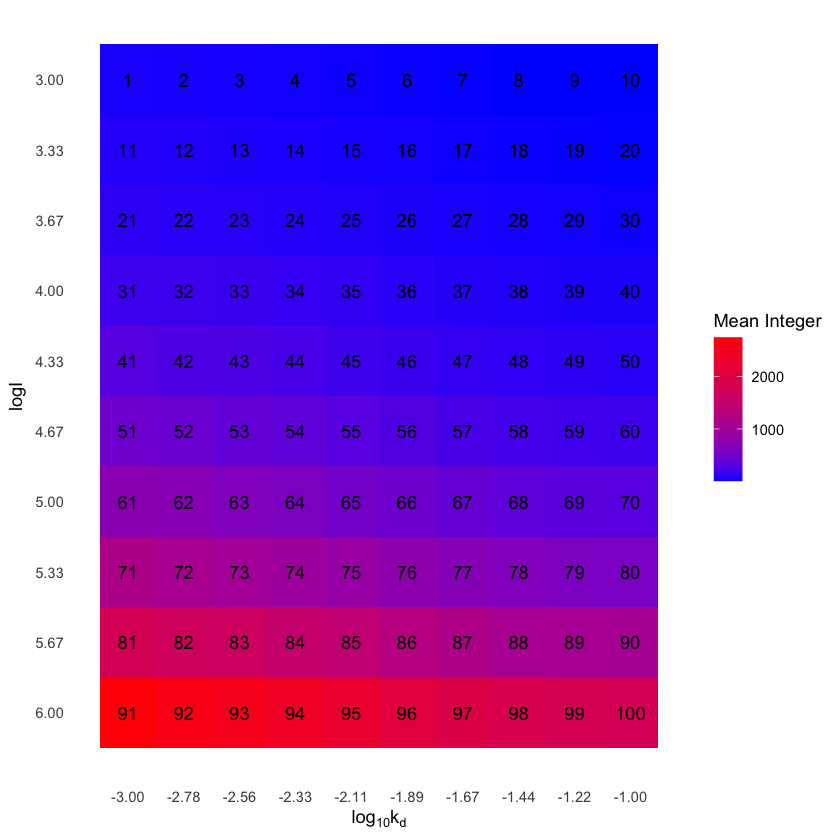

In [109]:
# Create a matrix for the heatmap
# heatmap_matrix <- matrix(seq(1,100,1), nrow = nrows, ncol = nrows) # TO VALIDATE
heatmap_matrix <- matrix(mean_integer$mean_integer, nrow = nrows, ncol = nrows)

# Create the heatmap
heatmap_plot <- ggplot(melt(heatmap_matrix), aes(Var1, Var2, fill = value)) +
    geom_tile() +
    scale_fill_gradient(low = "blue", high = "red") +
    labs(x = TeX("$\\log_{10} k_d$"), y = TeX("$\\log I$"), fill = "Mean Integer") +
    theme_minimal() +
    # Add x-labels based on the first 10 simulations (1,2,3,...)
    scale_x_continuous(breaks = 1:nrows, labels = sprintf("%.2f", log10(params$outflow_rate[seq(1, nrows, by = 1)]))) +
    # Add y-labels based on the simulations of the first row (1,11,21,...)
    scale_y_continuous(breaks = 1:nrows, labels = sprintf("%.2f", log10(params$inflow_mols[seq(1, nsims, by = nrows)]))) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

# Add sim_number text to each tile
heatmap_plot <- heatmap_plot +
    geom_text(aes(label = rep(mean_integer$sim_number)))

# Add a new reversed y-axis and re-apply the same labels
heatmap_plot <- heatmap_plot + 
    scale_y_reverse(breaks = 1:nrows, labels = sprintf("%.2f", log10(params$inflow_mols[seq(1, nsims, by = nrows)])))

print(heatmap_plot)

# Save the heatmap
ggsave("figs/heatmap.pdf", plot = heatmap_plot, width = 7, height = 6)